# News classification with topic models in gensim
News article classification is a task which is performed on a huge scale by news agencies all over the world. We will be looking into how topic modeling can be used to accurately classify news articles into different categories such as sports, technology, politics etc.

Our aim in this tutorial is to come up with some topic model which can come up with topics that can easily be interpreted by us. Such a topic model can be used to discover hidden structure in the corpus and can also be used to determine the membership of a news article into one of the topics.

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001.

Accompanying slides can be found [here](https://speakerdeck.com/dsquareindia/pycon-delhi-lightening).

### Requirements
In this tutorial we look at how different topic models can be easily created using [gensim](https://radimrehurek.com/gensim/).
Following are the dependencies for this tutorial:
    - Gensim Version >=0.13.1 would be preferred since we will be using topic coherence metrics extensively here.
    - matplotlib
    - nltk.stopwords and nltk.wordnet
    - pyLDAVis
We will be playing around with 4 different topic models here:
    - LSI (Latent Semantic Indexing)
    - HDP (Hierarchical Dirichlet Process)
    - LDA (Latent Dirichlet Allocation)
    - LDA (tweaked with topic coherence to find optimal number of topics) and
    - LDA as LSI with the help of topic coherence metrics
First we'll fit those topic models on our existing data then we'll compare each against the other and see how they rank in terms of human interpretability.

All can be found in gensim and can be easily used in a plug-and-play fashion. We will tinker with the LDA model using the newly added topic coherence metrics in gensim based on [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al and see how the resulting topic model compares with the exsisting ones.

In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

import nltk
nltk.download('stopwords') # Let's make sure the 'stopword' package is downloaded & updated
nltk.download('wordnet') # Let's also download wordnet, which will be used for lemmatization

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint
from smart_open import smart_open

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/NYCMath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/NYCMath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'

Analysing our corpus.
    - The first document talks about a bushfire that had occured in New South Wales.
    - The second talks about conflict between India and Pakistan in Kashmir.
    - The third talks about road accidents in the New South Wales area.
    - The fourth one talks about Argentina's economic and political crisis during that time.
    - The last one talks about the use of drugs by midwives in a Sydney hospital.
Our final topic model should be giving us keywords which we can easily interpret and make a small summary out of. Without this the topic model cannot be of much practical use.

In [3]:
with smart_open(lee_train_file, 'rb') as f:
    for n, l in enumerate(f):
        if n < 5:
            print([l])

[b'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at 

In [4]:
def build_texts(fname):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    with smart_open(fname, 'rb') as f:
        for line in f:
            yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [5]:
train_texts = list(build_texts(lee_train_file))

In [6]:
len(train_texts)

300

### Preprocessing our data. Remember: Garbage In Garbage Out
                                        "NLP is 80% preprocessing."
                                                                -Lev Konstantinovskiy
This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:
1. Stopword removal using NLTK's english stopwords dataset.
2. Bigram collocation detection (frequently co-occuring tokens) using gensim's [Phrases](https://radimrehurek.com/gensim/models/phrases.html). This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
3. Lemmatization (using gensim's [`lemmatize`](https://radimrehurek.com/gensim/utils.html#gensim.utils.lemmatize)) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [7]:
bigram = gensim.models.Phrases(train_texts)  # for bigram collocation detection

In [8]:
bigram[['new', 'york', 'example']]

['new_york', 'example']

In [9]:
from gensim.utils import lemmatize
from nltk.corpus import stopwords

In [10]:
stops = set(stopwords.words('english'))  # nltk stopwords list

In [11]:
def process_texts(texts):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    texts = [[word for word in lemmatizer.lemmatize(' '.join(line), pos='v').split()] for line in texts]
    return texts

In [12]:
train_texts = process_texts(train_texts)
train_texts[5:6]

[['federal_government',
  'says',
  'safe',
  'afghani',
  'asylum_seekers',
  'australia',
  'return',
  'home',
  'environment',
  'becomes',
  'secure',
  'government',
  'suspended',
  'applications',
  'interim_government',
  'established',
  'kabul',
  'foreign_affairs',
  'minister_alexander',
  'downer',
  'refused',
  'say',
  'long',
  'claims',
  'process',
  'put',
  'hold',
  'says',
  'major',
  'threat',
  'people',
  'seeking',
  'asylum',
  'longer',
  'many',
  'afghans',
  'tried',
  'get',
  'australia',
  'matter',
  'britain',
  'countries',
  'north',
  'west',
  'europe',
  'claimed',
  'fleeing',
  'taliban',
  'said',
  'well',
  'taliban',
  'longer',
  'power',
  'afghanistan',
  'taliban',
  'finished',
  'meanwhile',
  'mass',
  'airlift',
  'detainees',
  'christmas',
  'island',
  'pacific',
  'island',
  'nauru',
  'total',
  'people',
  'flown',
  'island',
  'two',
  'operations',
  'using',
  'chartered',
  'aircraft',
  'second',
  'airlift',
  'tod

Finalising our dictionary and corpus

In [13]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

### Topic modeling with LSI
This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. However it does require a `num_topics` parameter (set to 200 by default) to determine the number of latent dimensions after the SVD.

In [14]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [15]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.542*"said" + 0.349*"says" + 0.127*"arafat" + 0.122*"palestinian" + 0.118*"people" + 0.117*"israeli" + 0.112*"two" + 0.110*"australian" + 0.110*"also" + 0.107*"australia"'),
 (1,
  '-0.407*"says" + 0.322*"arafat" + 0.315*"palestinian" + 0.273*"israeli" + 0.192*"israel" + 0.173*"sharon" + -0.145*"australia" + -0.143*"australian" + 0.140*"west_bank" + 0.136*"hamas"'),
 (2,
  '0.348*"says" + -0.330*"said" + -0.202*"afghanistan" + -0.191*"bin_laden" + -0.178*"taliban" + -0.169*"pakistan" + 0.162*"australia" + 0.149*"arafat" + -0.126*"tora_bora" + 0.124*"israeli"'),
 (3,
  '0.293*"fire" + 0.240*"sydney" + -0.214*"says" + 0.185*"firefighters" + 0.171*"south" + 0.164*"wales" + 0.164*"new_south" + 0.162*"north" + 0.161*"fires" + -0.152*"afghanistan"'),
 (4,
  '-0.219*"said" + -0.171*"test" + -0.171*"match" + 0.154*"afghanistan" + 0.149*"government" + 0.149*"says" + -0.144*"first" + 0.142*"fire" + -0.139*"australia" + 0.135*"force"')]

In [16]:
lsitopics = lsimodel.show_topics(formatted=False)

### Topic modeling with [HDP](http://jmlr.csail.mit.edu/proceedings/papers/v15/wang11a/wang11a.pdf)
An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

In [17]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [18]:
hdpmodel.show_topics()

[(0,
  '0.005*said + 0.003*government + 0.003*sharon + 0.003*israeli + 0.003*says + 0.002*palestinian + 0.002*match + 0.002*security + 0.002*friedli + 0.002*people + 0.002*day + 0.002*arafat + 0.002*two + 0.002*killed + 0.002*president + 0.002*rabbani + 0.002*attacks + 0.002*know + 0.002*could + 0.002*gaza_strip'),
 (1,
  '0.004*said + 0.004*says + 0.004*arafat + 0.004*government + 0.002*sharon + 0.002*israeli + 0.002*help + 0.002*storm + 0.002*hit + 0.002*sydney + 0.002*ses + 0.002*palestinian + 0.002*trees + 0.002*homes + 0.002*yesterday + 0.001*official + 0.001*military + 0.001*services + 0.001*west_bank + 0.001*areas'),
 (2,
  '0.007*said + 0.005*taliban + 0.003*airport + 0.003*kandahar + 0.003*afghanistan + 0.003*also + 0.002*killed + 0.002*powell + 0.002*southern + 0.002*rumsfeld + 0.002*osama_bin + 0.002*city + 0.002*near + 0.002*bin_laden + 0.002*night + 0.002*forces + 0.002*opposition + 0.002*says + 0.001*civilians + 0.001*ground'),
 (3,
  '0.003*said + 0.003*harrison + 0.002*

In [19]:
hdptopics = hdpmodel.show_topics(formatted=False)

### Topic modeling using [LDA](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei. Let's choose 10 topics to initialize this.

In [20]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

pyLDAvis is a great way to visualize an LDA model. To summarize in short, the area of the circles represent the prevelance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. pyLDAvis is based on [this](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) paper.

In [21]:
import pyLDAvis.gensim

In [22]:
pyLDAvis.enable_notebook()

In [23]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      14.937812        1       1 -0.030426 -0.018566
4      14.726419        1       2  0.013321 -0.018077
0      14.686404        1       3 -0.006274  0.002086
3      11.353440        1       4  0.005066 -0.008713
2      10.948476        1       5  0.016785  0.003390
5      10.597322        1       6  0.030497 -0.038820
8       8.699680        1       7 -0.060536 -0.017802
6       7.151501        1       8  0.017973  0.015483
7       3.707002        1       9 -0.019485  0.060418
1       3.191944        1      10  0.033078  0.020600, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
98    Default  386.000000              said  386.000000  30.0000  30.0000
99    Default  346.000000              says  346.000000  29.0000  29.0000
356   Default  117.000000         australia  117.000000  28.0000  28.0000
986   Default  118.000000        australian  118.000000  27.0000  27.0000
200   Default   98.000000               two   98.000000  26.0000  26.0000
260   Default   36.000000     international   36.000000  25.0000  25.0000
126   Default   37.000000              year   37.000000  24.0000  24.0000
1029  Default   19.000000              best   19.000000  23.0000  23.0000
574   Default   92.000000              also   92.000000  22.0000  22.0000
2564  Default   35.000000             hamas   35.000000  21.0000  21.0000
329   Default  100.000000               one  100.000000  20.0000  20.0000
1075  Default   41.000000          per_cent   41.000000  19.0000  19.0000
6364  Default    8.000000             virus    8.000000  18.0000  18.0000
110   Default   46.000000            sydney   46.000000  17.0000  17.0000
4228  Default   13.000000             space   13.000000  16.0000  16.0000
693   Default   42.000000             force   42.000000  15.0000  15.0000
2713  Default   14.000000  governor_general   14.000000  14.0000  14.0000
349   Default   67.000000       afghanistan   67.000000  13.0000  13.0000
226   Default   49.000000              time   49.000000  12.0000  12.0000
303   Default   84.000000             would   84.000000  11.0000  11.0000
180   Default   56.000000               say   56.000000  10.0000  10.0000
207   Default   28.000000              died   28.000000   9.0000   9.0000
2115  Default   12.000000            cancer   12.000000   8.0000   8.0000
165   Default   25.000000         militants   25.000000   7.0000   7.0000
299   Default   63.000000              told   63.000000   6.0000   6.0000
393   Default   32.000000             power   32.000000   5.0000   5.0000
842   Default   38.000000           meeting   38.000000   4.0000   4.0000
2408  Default   20.000000             child   20.000000   3.0000   3.0000
2717  Default    9.000000            howard    9.000000   2.0000   2.0000
258   Default   99.000000        government   99.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
1075  Topic10    2.649449          per_cent   41.123596   0.7023  -5.9582
4554  Topic10    0.754942            center    3.599070   1.8828  -7.2137
226   Topic10    2.564524              time   49.727554   0.4798  -5.9908
99    Topic10    6.240379              says  346.235962  -0.5715  -5.1015
46    Topic10    2.172114              five   35.735088   0.6441  -6.1569
986   Topic10    3.639087        australian  118.665268  -0.0400  -5.6408
574   Topic10    3.197879              also   92.326698   0.0817  -5.7701
618   Topic10    1.363297             large   15.065476   1.0420  -6.6227
565   Topic10    1.508198             river   19.536182   0.8832  -6.5217
537   Topic10    2.155894             world   46.235317   0.3790  -6.1644
207   Topic10    1.756597              died   28.924841   0.6432  -6.3692
1695  Topic10    1.345698              head   15.1216

In [24]:
ldatopics = ldamodel.show_topics(formatted=False)

### Finding out the optimal number of topics
__Introduction to topic coherence__:
<img src="https://rare-technologies.com/wp-content/uploads/2016/06/pipeline.png">
Topic coherence in essence measures the human interpretability of a topic model. Traditionally [perplexity has been used](http://qpleple.com/perplexity-to-evaluate-topic-models/) to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases. Here's a short blog I wrote explaining topic coherence:
[What is topic coherence?](https://rare-technologies.com/what-is-topic-coherence/)

In [25]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

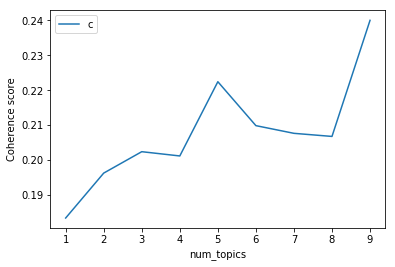

CPU times: user 11.3 s, sys: 862 ms, total: 12.2 s
Wall time: 14 s


In [26]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10)

In [27]:
pyLDAvis.gensim.prepare(lmlist[2], corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      37.830292        1       1  0.015896  0.011065
0      35.029160        1       2  0.002431 -0.018243
2      27.140553        1       3 -0.018326  0.007178, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
99    Default  337.000000         says  337.000000  30.0000  30.0000
356   Default  114.000000    australia  114.000000  29.0000  29.0000
150   Default   29.000000        india   29.000000  28.0000  28.0000
43    Default   50.000000         fire   50.000000  27.0000  27.0000
2115  Default   11.000000       cancer   11.000000  26.0000  26.0000
6364  Default    8.000000        virus    8.000000  25.0000  25.0000
200   Default   97.000000          two   97.000000  24.0000  24.0000
258   Default   94.000000   government   94.000000  23.0000  23.0000
304   Default   24.000000        years   24.000000  22.0000  22.0000
81    Default   33.000000    new_south   33.000000  21.0000  21.0000
2486  Default   22.000000      economy   22.000000  20.0000  20.0000
278   Default   41.000000    president   41.000000  19.0000  19.0000
171   Default   38.000000     pakistan   38.000000  18.0000  18.0000
2082  Default   45.000000       israel   45.000000  17.0000  17.0000
559   Default   28.000000    melbourne   28.000000  16.0000  16.0000
329   Default   99.000000          one   99.000000  15.0000  15.0000
1193  Default   14.000000         laws   14.000000  14.0000  14.0000
317   Default   23.000000     hospital   23.000000  13.0000  13.0000
105   Default   35.000000        state   35.000000  12.0000  12.0000
2551  Default   59.000000       arafat   59.000000  11.0000  11.0000
5478  Default    6.000000         lung    6.000000  10.0000  10.0000
236   Default   10.000000    argentina   10.000000   9.0000   9.0000
151   Default   25.000000       indian   25.000000   8.0000   8.0000
1112  Default   18.000000        peter   18.000000   7.0000   7.0000
207   Default   28.000000         died   28.000000   6.0000   6.0000
2533  Default   27.000000    tora_bora   27.000000   5.0000   5.0000
2743  Default   11.000000   east_timor   11.000000   4.0000   4.0000
241   Default   64.000000        could   64.000000   3.0000   3.0000
120   Default   33.000000        wales   33.000000   2.0000   2.0000
3975  Default    6.000000         club    6.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
200    Topic3   32.528534          two   97.784729   0.2035  -5.5909
329    Topic3   32.799381          one   99.464081   0.1948  -5.5826
356    Topic3   35.581409    australia  114.435806   0.1360  -5.5011
207    Topic3   12.200671         died   28.961609   0.4397  -6.5715
986    Topic3   35.287804   australian  117.083336   0.1048  -5.5094
241    Topic3   21.892807        could   64.313049   0.2265  -5.9868
450    Topic3   24.153099        first   74.244370   0.1812  -5.8886
98     Topic3   81.745369         said  381.522430  -0.2364  -4.6694
80     Topic3   23.066824          new   70.982819   0.1801  -5.9346
86     Topic3   29.994366       people  108.488434   0.0185  -5.6720
574    Topic3   26.379898         also   91.907181   0.0560  -5.8004
336    Topic3   10.061458          six   24.148529   0.4286  -6.7643
628    Topic3   13.828790      morning   38.990749   0.2676  -6.4462
798    Topic3    8.742858    community   20.068878   0.4732  -6.9047
225    Topic3   19.564890        three   68.108482   0.0568  -6.0992
81     Topic3   11.930621    new_south   33.298405   0.2777  -6.5939
214    Topic3   12.308861     national   34.947533   0.2606  -6.5626
46     Topic3   12.493853         five   35.774368   0.2521  -6.5477
303    Topic3   21.252211        would   83.253929  -0.0613  -6.0165
2738   Topic3   15.826243      company   54.119442   0.0746  -6.3113
171    Topic3   12.821650     

In [28]:
lmtopics = lmlist[5].show_topics(formatted=False)

### LDA as LSI

One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. Let us see if we can dig out the best topics from the best LDA model we can produce. The function below can be used to control the quality of the LDA model we produce.

In [29]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [ ]:
lm, top_topics = ret_top_model()

In [ ]:
print(top_topics[:5])

### Inference
We can clearly see below that the first topic is about __cinema__, second is about __email malware__, third is about the land which was given back to the __Larrakia aboriginal community of Australia__ in 2000. Then there's one about __Australian cricket__. LDA as LSI has worked wonderfully in finding out the best topics from within LDA.

In [ ]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

In [ ]:
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

### Evaluating all the topic models
Any topic model which can come up with topic terms can be plugged into the coherence pipeline. You can even plug in an [NMF topic model](http://derekgreene.com/nmf-topic/) created with scikit-learn.

In [ ]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [ ]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [ ]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [ ]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'LDA_LSI'])

### Customizing the topic coherence measure
Till now we only used the `c_v` coherence measure. There are others such as `u_mass`, `c_uci`, `c_npmi`. All of these calculate coherence in a different way. `c_v` is found to be most in line with human ratings but can be much slower than `u_mass` since it uses a sliding window over the texts.

### Making your own coherence measure
Let's modify `c_uci` to use `s_one_pre` instead of `s_one_one` segmentation

In [ ]:
from gensim.topic_coherence import (segmentation, probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort
from collections import namedtuple

In [ ]:
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

In [ ]:
measure = make_pipeline(segmentation.s_one_one,
                        probability_estimation.p_boolean_sliding_window,
                        direct_confirmation_measure.log_ratio_measure,
                        aggregation.arithmetic_mean)

To get topics out of the topic model:

In [ ]:
topics = []
for topic in lm.state.get_lambda():
    bestn = argsort(topic, topn=10, reverse=True)
topics.append(bestn)

__Step 1__: Segmentation

In [ ]:
# Perform segmentation
segmented_topics = measure.seg(topics)

__Step 2__: Probability estimation

In [ ]:
# Since this is a window-based coherence measure we will perform window based prob estimation
per_topic_postings, num_windows = measure.prob(texts=train_texts, segmented_topics=segmented_topics,
                                               dictionary=dictionary, window_size=2)

__Step 3__: Confirmation Measure

In [ ]:
confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=False)

__Step 4__: Aggregation

In [ ]:
print(measure.aggr(confirmed_measures))

# How this topic model can be used further
The best topic model here can be used as a standalone for news article classification. However a topic model can also be used as a dimensionality reduction algorithm to feed into a classifier. A good topic model should be able to extract the signal from the noise efficiently, hence improving the performance of the classifier.